# ECE 285 Final Project: Facial Expression Recognition
#### By Shivani Bhakta and Payal Singh 

# Imports

In [70]:
import glob
import numpy as np
import PIL
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as dset
from torch.utils.data import sampler
from torch.utils.data import DataLoader, Dataset, TensorDataset

import os
import os.path as osp
import cv2 
import sys
import copy

from woodnet import *
from MyNet import *

## Crop and resize images
- We use the MTCNN face detector to recognize face in our dataset and crop each images and resize them to 224 x 224. Do this by running the PrepData.py file. Use the command ``` python PrepData.py``` in terminal
- We then store them into a new folder
- https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## Tufts Face DB 
In this project we use a dataset named Tufts Face Database for Facial Recognition. This dataset is made up with over 10,000 images of 74 female and 38 males from more than 15 countries with the age range between 4-70 years old. This dataset contains 7 image modalities, but we only use a subset of it, from the Tufts Face Database 2D RGB Expression (TDRGBA). This set contains 5 images of 50 different people. These 5 images are of 5 different expressions (neutral, smiling, eyes closed, surprised, and sunglasses). 

## Visualize the dataset

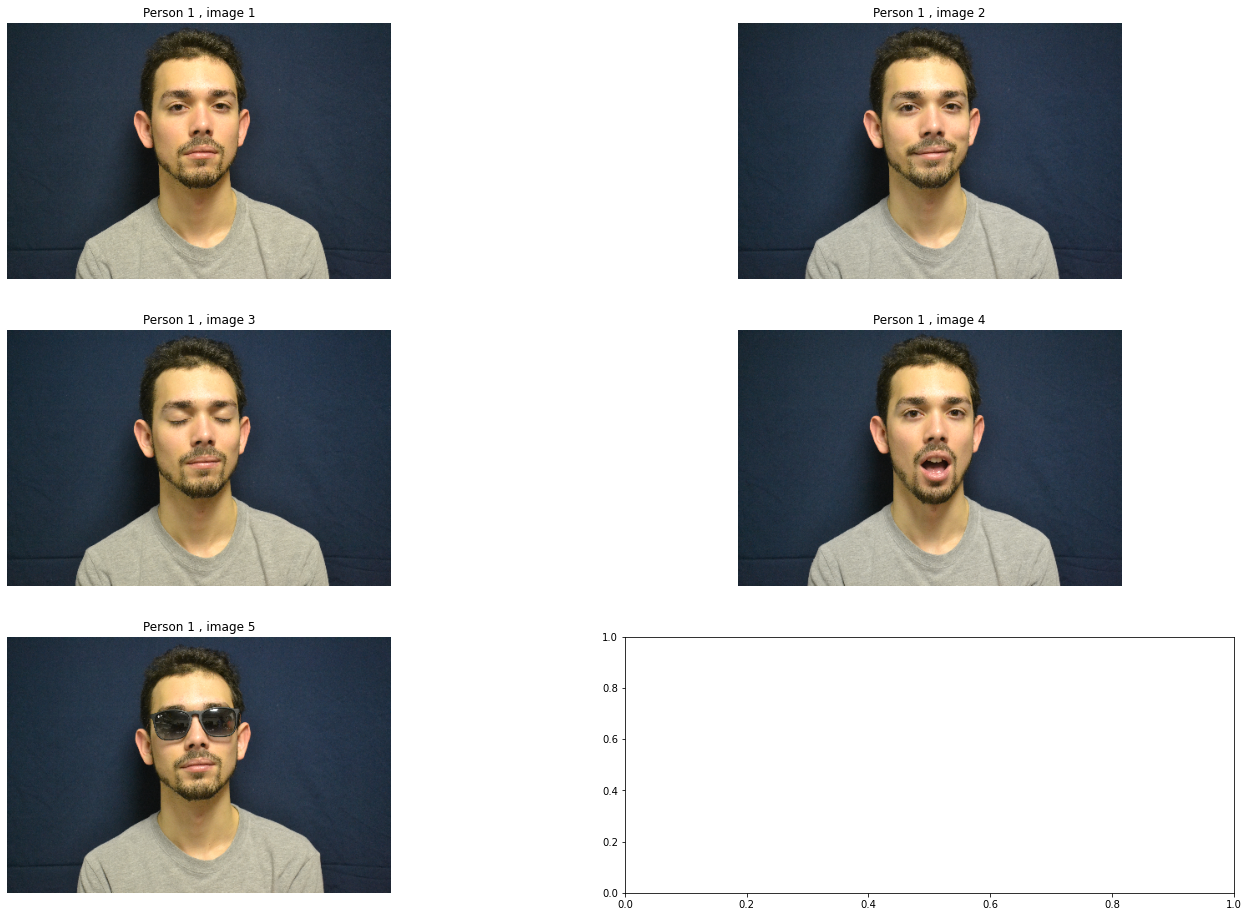

In [6]:
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 16))
# for person in range(1, 51): 
#     if person == 47: continue
#     for idx in range(1,6):
#         t = 'dataset/' + str(person) + '/TD_RGB_E_{}.jpg'.format(idx)

#         im = Image.open(t)
#         width, height = im.size    # orig image size: (3072, 4608)

#         newsize = (width//10, height//10)
#         im2 = im.resize(newsize)    # resized Image Size:  (460, 307)
    
#         fn = 'TD_RGB_E_{}_{}.jpg'.format(person,idx)
#         im2.save('cropped/' + fn)
    
#         if person == 1:    # Display all of the images of Person 1
#             if idx in [1,2]: 
#                 i = 0
#                 j = idx - 1
#             elif idx in [3,4]:
#                 i = 1
#                 j = idx - 3    
#             else: 
#                 i = 2
#                 j = idx - 5 
#             axes[i][j].axis('off')
#             axes[i][j].imshow(im2)
#             axes[i][j].set_title(f'Person 1, image {idx}')

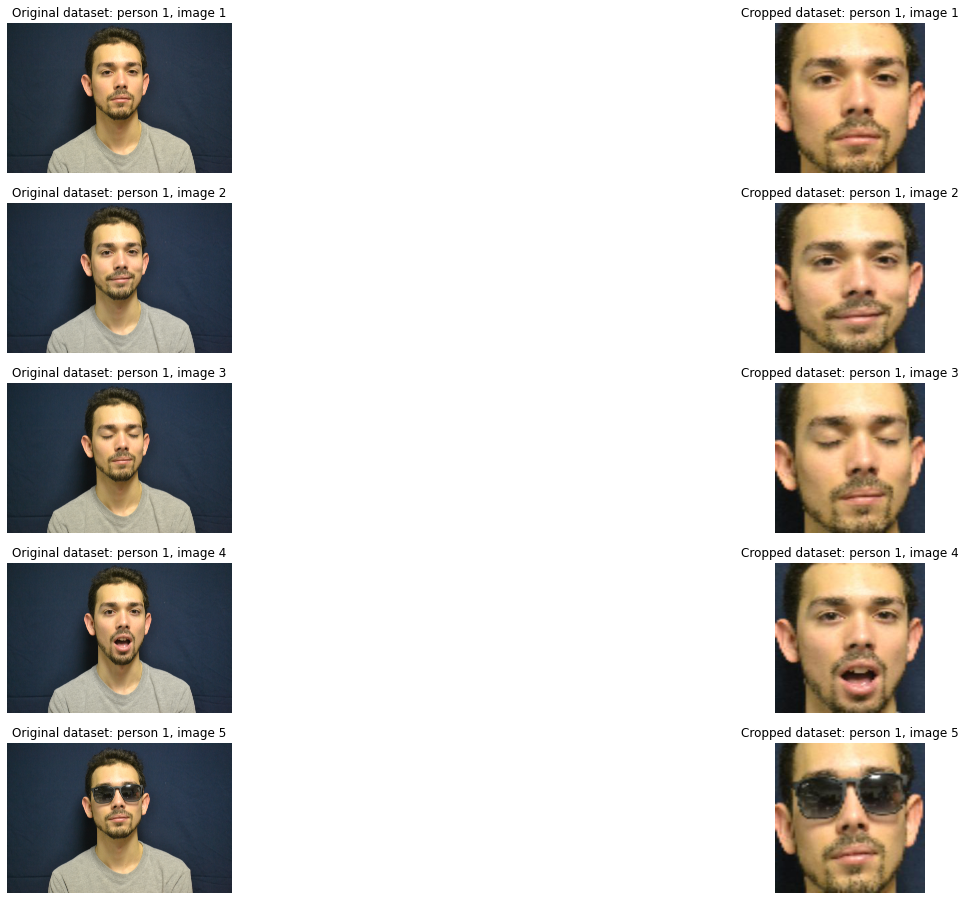

In [3]:
person = 1    # do not choose 47 (this participant withdrew from the dataset)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(24, 16))

if person == 47: 
    print('Cannot display Participant 47')
for idx in np.arange(1, 6):
    # original dataset images
    orig_im = Image.open(f'dataset/{person}/TD_RGB_E_{idx}.jpg')
    # cropped dataset images
    im = Image.open(f'cropped/TD_RGB_E_{person}_{idx}.jpg')
    # Display all of the images of selected person
    axes[idx-1][0].axis('off')
    axes[idx-1][0].imshow(orig_im)
    axes[idx-1][0].set_title(f'Original dataset: person {person}, image {idx}')
    axes[idx-1][1].axis('off')
    axes[idx-1][1].imshow(im)
    axes[idx-1][1].set_title(f'Cropped dataset: person {person}, image {idx}')

In [28]:
def get_faces():
    '''
    input: 
        n: number of images to load from the folder. 
    output: 
        neutral_faces: numpy array with each column corresponds to a data point (each image of neutral faces) 
        smiling_faces: numpy array with each column corresponds to a data point (each image of smiling faces)
    '''
    n = 49    # number of people in dataset
    
    neutral_faces = np.zeros((n,3,224,224))
    smiling_faces = np.zeros((n,3,224,224))
    eyesclosed_faces = np.zeros((n,3,224,224))
    surprised_faces = np.zeros((n,3,224,224))
    sunglasses_faces = np.zeros((n,3,224,224))

    for i in range(1,n+1):
        if i == 47: continue
        for j in range(1,6):
            image_path = f'cropped/TD_RGB_E_{i}_{j}.jpg'
            p = Image.open(image_path)
            # this is where to do data augmentation
            p = np.transpose(np.array(p))
        
            if j == 1: neutral_faces[i-1,:] = p
            elif j == 2: smiling_faces[i-1,:] = p
            elif j ==3: eyesclosed_faces[i-1,:] = p
            elif j == 4: surprised_faces[i-1,:] = p
            elif j == 5: sunglasses_faces[i-1,:] = p

    return neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces

neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces = get_faces()
print(neutral_faces.shape)

(49, 3, 224, 224)


In [71]:
def augmentation_and_transp(p):
    
    p1 = p.transpose(PIL.Image.FLIP_LEFT_RIGHT)    # flip image across vertical axis
    p2 = p.rotate(5)
    p3 = p.rotate(-5)
    p4 = p.rotate(10)
    p5 = p.rotate(-10)
    
    #image brightness enhancer
    enhancer = ImageEnhance.Brightness(im)
    p6 = enhancer.enhance(0.5)
    p7 = enhancer.enhance(1.5)
    
    p = np.transpose(np.array(p))
    p1 = np.transpose(np.array(p1))
    p2 = np.transpose(np.array(p2))
    p3 = np.transpose(np.array(p3))
    p4 = np.transpose(np.array(p4))
    p5 = np.transpose(np.array(p5))
    p6 = np.transpose(np.array(p6))
    p7 = np.transpose(np.array(p7))
    
    return p, p1,  p2,  p3, p4,  p5, p6, p7

def get_faces1():
    '''
    input: 
        n: number of images to load from the folder. 
    output: 
        neutral_faces: numpy array with each column corresponds to a data point (each image of neutral faces) 
        smiling_faces: numpy array with each column corresponds to a data point (each image of smiling faces)
    '''
    n = 49    # number of people in dataset
    
    neutral_faces = []
    smiling_faces = []
    eyesclosed_faces = []
    surprised_faces = []
    sunglasses_faces = []

    for i in range(1,n+1):
        if i == 47: continue
        for j in range(1,6):
            image_path = f'cropped/TD_RGB_E_{i}_{j}.jpg'
            p = Image.open(image_path)
            p, p1, p2, p3, p4, p5, p6, p7 = augmentation_and_transp(p)    # data augmentation and transposing
        
            if j == 1: 
                neutral_faces.extend([p, p1, p2, p3, p4, p5, p6, p7])
            elif j == 2: 
                smiling_faces.extend([p, p1, p2, p3, p4, p5, p6, p7])
            elif j ==3: 
                eyesclosed_faces.extend([p, p1, p2, p3, p4, p5, p6, p7])
            elif j == 4: 
                surprised_faces.extend([p, p1, p2, p3, p4, p5, p6, p7])
            elif j == 5: 
                sunglasses_faces.extend([p, p1, p2, p3, p4, p5, p6, p7])

    return np.array(neutral_faces), np.array(smiling_faces), np.array(eyesclosed_faces), np.array(surprised_faces), np.array(sunglasses_faces)

neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces = get_faces1()
print(np.shape(neutral_faces))

(384, 3, 224, 224)


In [75]:
# dataset
data = np.vstack((neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces))
labels_0 = [0] * len(neutral_faces)
labels_1 = [1] * len(smiling_faces)
labels_2 = [2] * len(eyesclosed_faces)
labels_3 = [3] * len(surprised_faces)
labels_4 = [4] * len(sunglasses_faces)

labels = labels_0 + labels_1 + labels_2 + labels_3 + labels_4
labels = np.array(labels)
idxs = list(range(np.shape(neutral_faces)[0]*5))   # will change if do different number of transforms for data augmentation
np.random.shuffle(idxs)

data = data[idxs]
labels = labels[idxs]
print("Total data shape: ", data.shape)

test_train_split = 0.88889
train_data = data[:int(test_train_split * len(idxs))]
train_labels = labels[:int(test_train_split * len(idxs))]
print("Train data shape: ", train_data.shape)

test_data = data[int(test_train_split * len(idxs)):]
test_labels = labels[int(test_train_split * len(idxs)):]
print("Test data shape: ", test_data.shape)

image = test_data[0]
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print("Individual Image size: ", image.shape)

Total data shape:  (1920, 3, 224, 224)
Train data shape:  (1706, 3, 224, 224)
Test data shape:  (214, 3, 224, 224)
Individual Image size:  (1, 3, 224, 224)


In [76]:
class MyDataset(Dataset):
    ''' This class formats the dataset into a iterable-style dataset needed for the dataloader'''
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        data = {'x': x, 'y': y}
        return data
    
    def __len__(self):
        return len(self.data)

# trans = [T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
train_data = MyDataset(train_data, train_labels)
test_data = MyDataset(test_data, test_labels)
# dataloader = DataLoader(dataset, batch_size=5)

# Model 

#### Create a function to check the accuracy 

In [77]:
NUM_TRAIN = len(train_data)
NUM_TEST = len(test_data)

def check_accuracy(loader, model):
  
    num_correct = 0
    num_samples = 0
    loss = 0.00
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for data in loader:
            x = data['x'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = data['y'].to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            loss = F.cross_entropy(scores,y) + loss
            
        acc = float(num_correct) / num_samples
        loss = loss/ num_samples
        
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
        return acc, loss

#### Create a function for training and validation 

In [78]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model lol
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_arr = []
    test_loss_arr = []
    test_acc_arr =[]
    model = model.to(device=device)  # move the model parameters to CPU/GPU
  
    for e in range(epochs):
        model.train() # put model to training mode
        for t, data in enumerate(loader_train):
            x = data['x'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = data['y'].to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            if t == 0:
                iter_loss = loss.item()
            else:
                iter_loss = iter_loss + loss.item()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print(f'Epoch {e}, Iteration {t}, loss = {loss.item():.7f}')
#                 acc_Val, loss_Val = check_accuracy(loader_val, model)
#                 print()
        loss_arr.append(iter_loss/t)
    
        model.eval()
        acc_Val, loss_Val = check_accuracy(loader_test, model)
        test_loss_arr.append(loss_Val)
        test_acc_arr.append(acc_Val)
    
    # plot loss and accuracy
    f, axes = plt.subplots(2, constrained_layout=True)
    axes[0].plot(loss_arr, label="Train loss")
#     axes[0].plot(test_loss_arr, label = 'Test loss')
    axes[0].set_title('Loss History')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')
    
    axes[1].plot(test_acc_arr, label="Test accuracy")
    axes[1].set_title('Accuracy History')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Accuracy')

In [79]:
loader_train = DataLoader(train_data, batch_size=12, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
#                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
#                             transform=transform_test)
loader_test = DataLoader(test_data, batch_size=4)

## WoodNet

Epoch 0, Iteration 0, loss = 1.5904640
Epoch 0, Iteration 10, loss = 1.6479527
Epoch 0, Iteration 20, loss = 1.6310190
Epoch 0, Iteration 30, loss = 1.6261330
Epoch 0, Iteration 40, loss = 1.7409258
Epoch 0, Iteration 50, loss = 1.5968313
Epoch 0, Iteration 60, loss = 1.4753908
Epoch 0, Iteration 70, loss = 1.1656944
Epoch 0, Iteration 80, loss = 1.1941767
Epoch 0, Iteration 90, loss = 1.3716811
Epoch 0, Iteration 100, loss = 1.3551542
Epoch 0, Iteration 110, loss = 1.1425744
Epoch 0, Iteration 120, loss = 1.1930311
Epoch 0, Iteration 130, loss = 1.0219731
Epoch 0, Iteration 140, loss = 0.7337802
Got 121 / 214 correct (56.54)
Epoch 1, Iteration 0, loss = 1.1788930
Epoch 1, Iteration 10, loss = 0.8054674
Epoch 1, Iteration 20, loss = 0.6030267
Epoch 1, Iteration 30, loss = 0.8024290
Epoch 1, Iteration 40, loss = 0.8405491
Epoch 1, Iteration 50, loss = 0.4624924
Epoch 1, Iteration 60, loss = 1.1124992
Epoch 1, Iteration 70, loss = 0.6543408
Epoch 1, Iteration 80, loss = 0.6099901
Epoch 1

Got 175 / 214 correct (81.78)
Epoch 13, Iteration 0, loss = 0.2903258
Epoch 13, Iteration 10, loss = 0.2977879
Epoch 13, Iteration 20, loss = 0.5786560
Epoch 13, Iteration 30, loss = 0.4087149
Epoch 13, Iteration 40, loss = 0.5362867
Epoch 13, Iteration 50, loss = 0.6749935
Epoch 13, Iteration 60, loss = 0.6770246
Epoch 13, Iteration 70, loss = 0.6535434
Epoch 13, Iteration 80, loss = 0.9387774
Epoch 13, Iteration 90, loss = 0.5032238
Epoch 13, Iteration 100, loss = 0.2366397
Epoch 13, Iteration 110, loss = 0.5488241
Epoch 13, Iteration 120, loss = 0.5528051
Epoch 13, Iteration 130, loss = 0.1328100
Epoch 13, Iteration 140, loss = 0.3245227
Got 166 / 214 correct (77.57)
Epoch 14, Iteration 0, loss = 0.4327255
Epoch 14, Iteration 10, loss = 0.6630138
Epoch 14, Iteration 20, loss = 0.6411892
Epoch 14, Iteration 30, loss = 0.2888291
Epoch 14, Iteration 40, loss = 0.2071064
Epoch 14, Iteration 50, loss = 0.3946575
Epoch 14, Iteration 60, loss = 0.2597816
Epoch 14, Iteration 70, loss = 0.46

Epoch 25, Iteration 100, loss = 0.1362420
Epoch 25, Iteration 110, loss = 0.6829771
Epoch 25, Iteration 120, loss = 0.5393282
Epoch 25, Iteration 130, loss = 0.2644981
Epoch 25, Iteration 140, loss = 0.9377019
Got 178 / 214 correct (83.18)
Epoch 26, Iteration 0, loss = 0.3960158
Epoch 26, Iteration 10, loss = 0.2667061
Epoch 26, Iteration 20, loss = 0.5390611
Epoch 26, Iteration 30, loss = 0.9388230
Epoch 26, Iteration 40, loss = 0.5356353
Epoch 26, Iteration 50, loss = 0.6667374
Epoch 26, Iteration 60, loss = 0.1356163
Epoch 26, Iteration 70, loss = 0.4042616
Epoch 26, Iteration 80, loss = 0.2681619
Epoch 26, Iteration 90, loss = 0.5362599
Epoch 26, Iteration 100, loss = 0.4042593
Epoch 26, Iteration 110, loss = 0.2694454
Epoch 26, Iteration 120, loss = 0.5391636
Epoch 26, Iteration 130, loss = 0.4019271
Epoch 26, Iteration 140, loss = 0.5386067
Got 174 / 214 correct (81.31)
Epoch 27, Iteration 0, loss = 0.2636390
Epoch 27, Iteration 10, loss = 0.4025903
Epoch 27, Iteration 20, loss =

Epoch 38, Iteration 50, loss = 0.1342815
Epoch 38, Iteration 60, loss = 0.5345311
Epoch 38, Iteration 70, loss = 0.4035594
Epoch 38, Iteration 80, loss = 0.4021380
Epoch 38, Iteration 90, loss = 0.2690094
Epoch 38, Iteration 100, loss = 0.4038172
Epoch 38, Iteration 110, loss = 0.0000161
Epoch 38, Iteration 120, loss = 0.6694291
Epoch 38, Iteration 130, loss = 0.5414541
Epoch 38, Iteration 140, loss = 0.8107823
Got 167 / 214 correct (78.04)
Epoch 39, Iteration 0, loss = 0.2663120
Epoch 39, Iteration 10, loss = 0.5257137
Epoch 39, Iteration 20, loss = 0.3105133
Epoch 39, Iteration 30, loss = 0.3441591
Epoch 39, Iteration 40, loss = 0.4839306
Epoch 39, Iteration 50, loss = 0.8421154
Epoch 39, Iteration 60, loss = 0.1778983
Epoch 39, Iteration 70, loss = 0.5681557
Epoch 39, Iteration 80, loss = 1.0646806
Epoch 39, Iteration 90, loss = 0.5285614
Epoch 39, Iteration 100, loss = 0.6730174
Epoch 39, Iteration 110, loss = 0.2555999
Epoch 39, Iteration 120, loss = 0.5370977
Epoch 39, Iteration 

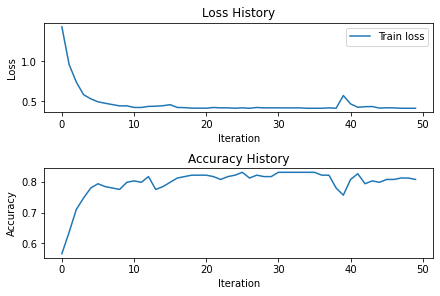

In [80]:
# define WoodNet
model = WoodNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print_every = 10
train_model(model, optimizer, epochs=50)
# without image augmentation, test accuracy was 20/28 ~= 71.4%

In [81]:
# test set accuracy
# comet.ml 
# tqdm 
check_accuracy(loader_test, model)

Got 173 / 214 correct (80.84)


(0.8084112149532711, tensor(0.0966, device='cuda:0'))

## MyNet

In [29]:
# define neural network

model = MyNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print_every = 10
train_model(model, optimizer, epochs=100)

RuntimeError: size mismatch, m1: [12 x 3211264], m2: [50176 x 2048] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:273

In [ ]:
# test set accuracy
check_accuracy(loader_test, model)

## Try getting Pre-trained Model  

In [19]:
import torch
model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=True)
model.eval()

# if torch.cuda.is_available():
#     train_data = train_data#.to('cuda')
#     model.to('cuda')
for t, data in enumerate(loader_train): 
    with torch.no_grad():
        output = model()
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print(probabilities)

Downloading: "https://github.com/pytorch/vision/archive/v0.8.2.zip" to /tmp/xdg-cache/torch/hub/v0.8.2.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /tmp/xdg-cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:03<00:00, 70.6MB/s] 


TypeError: forward() missing 1 required positional argument: 'x'

In [ ]:
# import torchvision
# vgg19 = torchvision.models.vgg19(pretrained=True)

# vgg19.classifier[1] = nn.Conv2d(vgg19.classifier[1].in_channels,5,1,1)

from torchvision import datasets, models, transforms
 
squeezenet = models.squeezenet1_1(pretrained=True, progress=True)
# Replace the last layer with one with the correct number of channels
network.load_state_dict
num_ftr = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(num_ftr, 5, 1, 1)
# squeezenet

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()

from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

# predict the probability across all output classes
yhat = model.predict(image)

In [ ]:
def test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, n): 
# def test(neutral_faces,smiling_faces,eyesclosed_faces, n): 
    '''
    Function to test that I am able to recontruct the original image with after all the reshaping and shaping.
    Checking the dimensions and shape as well. 
    '''
    print(neutral_faces.shape)

    plt.subplot(1,5,1)
    plt.imshow((neutral_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,2)
    plt.imshow((smiling_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,3)
    plt.imshow((eyesclosed_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,4)
    plt.imshow((surprised_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,5)
    plt.imshow((sunglasses_faces[:,n]).reshape((224,224)))

# Executing test function        
# test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, 25)  

5/27 to do next:
- need dataloader
- figure out if data is already centered (if not, how to do it for PCA)
- feature extraction (PCA)
- train our ELMAN RNN (link for how to use RNN with Pytorch: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch, https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- find optimal weights
- test
- try out other types of netral networks

Reference* Any publication using this database must reference to this:
- Website: http://tdface.ece.tufts.edu/ and this
- Paper: Panetta, Karen, Qianwen Wan, Sos Agaian, Srijith Rajeev, Shreyas Kamath, Rahul Rajendran, Shishir Rao et al. "A comprehensive database for benchmarking imaging systems." IEEE Transactions on Pattern Analysis and Machine Intelligence (2018).
- R Vemulapalli, A Agarwala, “A Compact Embedding for Facial Expression Similarity”, CoRR, abs/1811.11283, 2018.